# Probabilistic Topic Modeling

This tutorial implements the ProdLDA topic model from [Autoencoding Variational Inference For Topic Models](https://arxiv.org/abs/1703.01488) by Akash Srivastava and Charles Sutton. This model returns consistently better topics than vanilla LDA and trains much more quickly. Furthermore, it does not require a custom inference algorithm that relies on complex mathematical derivations. This tutorial also serves as an introduction to probabilistic modeling with Pyro, and is heavily inspired by [Probabilistic topic models](http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf) from David Blei.

## Introduction
Topic models are a suite of unsupervised learning algorithms that aim to discover and annotate large archives of documents with thematic information. Probabilistic topic models use statistical methods to analyze the words in each text to discover common themes, how those themes are connected to each other, and how they change over time. They enable us to organize and summarize electronic archives at a scale that would be impossible with human annotation alone. The most popular topic model is called latent Dirichlet allocation, or LDA.

## Latent Dirichlet Allocation: Intuition
LDA is a statistical model of document collections that encodes the intuition that documents exhibit multiple topics. It is most easily described by its generative process, the idealized random process from which the model assumes the documents were generated. The figure below illustrates the intuition:

<img src="https://i.ibb.co/zV5rjX6/Screen-Shot-2020-09-24-at-11-21-38.png" alt="image1">
<center>Figure 1: The intuition behind Latent Dirichlet Allocation (Blei 2012).</center>

We assume that there is a given number of “topics,” each of which is a probability distributions over words in the vocabulary (far left). Each document is assumed to be generated as follows: i) first, randomly choose a distribution over the topics (the histogram on the right); ii) then, for each word, randomly choose a topic assignment (the colored coins), and randomly choose the word from the corresponding topic. For an in-depth intuitive description, please check the excellent article from David Blei.

The goal of topic modeling is to automatically discover the topics from a collection of documents. The documents themselves are observed, while the topic structure — the topics, per-document topic distributions, and the per-document per-word topic assignments — is **hidden**. The central computational problem for topic modeling is to **use the observed documents to infer the hidden topic structure**.

We will now see how easy it is to implement this model in Pyro.

## Probabilistic Modeling and the Dirichlet distribution in Pyro
LDA is part of the larger field of probabilistic modeling. If you are already familiar with probabilistic modeling and Pyro, feel free to skip to the next section: [LDA pseudocode, mathematical form, and graphical model](#LDA-pseudocode,-mathematical-form,-and-graphical-model); if not, read on!

In generative probabilistic modeling, we treat our data as arising from a generative process that includes hidden variables. This generative process defines a joint probability distribution over both the observed and hidden random variables. We perform data analysis by using that joint distribution to compute the conditional distribution of the hidden variables given the observed variables. This conditional distribution is also called the posterior distribution.

To understand how probabilistic modeling and Pyro work, let's imagine a very simple example. Let's say we have a dice and we want to determine whether it is loaded or fair. We cannot directly observe the dice's 'fairness'; we can only infer it by throwing the dice and observing the results. So, we throw it 30 times and observe the following results:

$$ \mathcal{D} = \{5, 4, 2, 5, 6, 5, 3, 3, 1, 5, 5, 3, 5, 3, 5, 3, 5, 5, 3, 5, 5, 3, 1, 5, 3, 3, 6, 5, 5, 6\} $$

Counting the occurrences of each result:

| Digit | 1 | 2 | 3 | 4 | 5  | 6 |
|-------|---|---|---|---|----|---|
| Count | 2 | 1 | 9 | 1 | 14 | 3 |

For a fair dice, we should expect roughly 5 occurrences of each of the 6 digits in 30 throws. That is not, however, what we observed: numbers 3 and 5 are much more frequent, while 2 and 4 are especially infrequent. This is not a surprise, as we used a random number generator with the following probabilities to generate the dataset $\mathcal{D}$:

$$ P = \{0.12, 0.06, 0.26, 0.12, 0.32, 0.12\} $$

In the general case, however, the probabilities that generated the dataset are hidden to us: they are latent random variables. We don't have access to them, only the observations $\mathcal {D}$. The purpose of probabilistic modeling is to learn the hidden variables from the observations only.

Suppose we observe N dice rolls, $\mathcal{D} = \{x_1, ..., x_n\}$, where $x_i \in \{1, ..., 6\}$. If we assume the data is independent and identically distributed (iid), the likelihood of observing this specific dataset has the form 

\begin{equation*}
p(\mathcal{D} | \theta) = \prod_{i}^{6} \theta_{k}^{N_k}
\label{eq:multinomial} \tag{1}
\end{equation*}

where $N_k$ is the number of times we observed every digit $k$. The likelihood for the **multinomial distribution** has the same form: this is the best distribution to model this simple example. But how to model the latent random variable $\theta$?

$\theta$ is a vector of dimension 6 (one for each digit) that lives in the 6-dimensional probability simplex, i.e. the probabilities are all positive real numbers that add up to 1. There is a natural distribution for such probability vectors: the **Dirichlet distribution**. Indeed the Dirichlet distribution is commonly used as a prior distribution in Bayesian statistics, since it is "conjugate" to the multinomial (and categorical) distributions.

The Dirichlet distribution is parameterized by the vector $\alpha$, which has the same number of elements as our multinomial parameter $\theta$ (6 in our example). Although in this simple case we could compute the posterior over the hidden variables $\theta$ and $\alpha$ analytically, let's instead see how we can use Pyro and Markov Chain Monte Carlo (MCMC) to do inference:

In [1]:
import os
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

assert pyro.__version__.startswith('1.6.0')
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [2]:
def model(counts):
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones(6)))
    total_count = int(counts.sum())
    pyro.sample('counts', dist.Multinomial(total_count, theta), obs=counts)

data = torch.tensor([5, 4, 2, 5, 6, 5, 3, 3, 1, 5, 5, 3, 5, 3, 5, \
                     3, 5, 5, 3, 5, 5, 3, 1, 5, 3, 3, 6, 5, 5, 6])
counts = torch.unique(data, return_counts=True)[1].float()

nuts_kernel = NUTS(model)
num_samples, warmup_steps = (1000, 200) if not smoke_test else (10, 10)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(counts)
hmc_samples = {k: v.detach().cpu().numpy() 
               for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:14, 84.63it/s, step size=7.57e-01, acc. prob=0.909]


In [ ]:
means = hmc_samples['theta'].mean(axis=0)
stds = hmc_samples['theta'].std(axis=0)
print('Inferred dice probabilities from the data (68% confidence intervals):')
for i in range(6):
    print('%d: %.2f ± %.2f' % (i + 1, means[i], stds[i]))

There we go! By conditioning the generative model on the observations, we were able to infer the hidden random variables using MCMC. We see that 3 and 5 have higher inferred probabilities, as we observed in the dataset. The inferences are well aligned with the true probabilities that generated the data.

Before we move on, a final comment. Instead of using the `data` directly, we used the `counts`, summarizing the number of occurrences of each digit in the dataset. That's because the multinomial distribution models the probability of counts for each side of a $k$-sided dice rolled $n$ times. Alternatively, we could have used `data` directly, without summarizing. To do that, we just need to replace the multinomial distribution by the **categorical distribution**, a special case of the multinomial with $n = 1$:

In [4]:
def model(data):
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones(6)))
    with pyro.plate('data', len(data)):
        pyro.sample('obs', dist.Categorical(theta), obs=data)

nuts_kernel = NUTS(model)
num_samples, warmup_steps = (1000, 200) if not smoke_test else (10, 10)
mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
mcmc.run(data - 1)  # -1: we need to work with indices [0, 5] instead of [1, 6]
hmc_samples = {k: v.detach().cpu().numpy() 
               for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [00:10, 112.07it/s, step size=6.78e-01, acc. prob=0.922]


In [5]:
means = hmc_samples['theta'].mean(axis=0)
stds = hmc_samples['theta'].std(axis=0)
print('Inferred dice probabilities from the data (68% confidence intervals):')
for i in range(6):
    print('%d: %.2f ± %.2f' % (i + 1, means[i], stds[i]))

Inferred dice probabilities from the data (68% confidence intervals):
1: 0.08 ± 0.05
2: 0.06 ± 0.04
3: 0.28 ± 0.08
4: 0.06 ± 0.04
5: 0.42 ± 0.08
6: 0.11 ± 0.05


As expected, this produces the same inferences as computed earlier. Now that we've had a brief introduction to probabilistic programming in Pyro and reviewed a simple application of Dirichlet and multinomial/categorical distributions, we are ready to resume our LDA tutorial. 

## LDA pseudocode, mathematical form, and graphical model

We can define LDA more formally in 3 different ways: via pseudocode, via the mathematical form of the joint distribution, and via a probabilistic graphical model. Let's start with the **pseudocode**.

Each document of the collection is represented as a mixture of topics, where each topic $\beta_k$ is a probability distribution over the vocabulary (see the distributions over words on the left in Figure 1). We also use $\beta$ to denote the matrix $\beta = (\beta_1, ..., \beta_k)$. The generative process is then as described in the following algorithm:

<img src="https://i.ibb.co/3pyQfCV/Screen-Shot-2020-09-24-at-21-31-39.png" alt="image2" width="400">
<center>Figure 2: Pseudocode for the generative process.</center>

The topic proportions for the $d$-th document are denoted as $\theta_d$, where $\theta_{d, k}$ is the topic proportion
for topic $k$ in document $d$ (see the cartoon histogram in Figure 1). The topic assignments for the $d$-th document are denoted as $z_d$, where $z_{d, n}$ is the topic assignment for the $n$-th word in document $d$ (see the colored coin in Figure 1). Finally, the observed words for document $d$ are denoted as $w_d$, where $w_{d, n}$ is the $n$-th word in document $d$, which is an element from the fixed vocabulary.

Now, let's look at the **mathematical form** of the joint distribution. Given the parameters $\alpha$ and $\beta$, the joint distribution of a topic mixture $\theta$, a set of $N$ topics $\bf z$, and a set of $N$ words $\bf w$ is given by:

\begin{equation*}
p(\theta, \mathbf{z}, \mathbf{w} | \alpha, \beta) = p(\theta | \alpha) \prod_{n=1}^{N} p(z_n | \theta) p(w_n | z_n, \beta) ,
\label{eq:joint1} \tag{2}
\end{equation*}

where $p(z_n | \theta)$ is simply $\theta_i$ for the unique $i$ such that $z_n^i = 1$. Integrating over $\theta$ and summing over $z$, we obtain the marginal distribution of a document:

\begin{equation*}
p(\mathbf{w} | \alpha, \beta) = \int_{\theta} \Bigg( \prod_{n=1}^{N} \sum_{z_n=1}^{k} p(w_n | z_n, \beta) p(z_n | \theta) \Bigg) p(\theta | \alpha) d\theta ,
\label{eq:joint2} \tag{3}
\end{equation*}

while taking the product of the marginal probabilities of single documents, we obtain the probability of a corpus:

\begin{equation*}
p(\mathcal{D} | \alpha, \beta) = \prod_{d=1}^{M} \int_{\theta} \Bigg( \prod_{n=1}^{N_d} \sum_{z_{d,n}=1}^{k} p(w_{d,n} | z_{d,n}, \beta) p(z_{d,n} | \theta_d) \Bigg) p(\theta_d | \alpha) d\theta_d .
\label{eq:joint3} \tag{4}
\end{equation*}

Notice that this distribution specifies a number of (statistical) dependencies. For example, the topic assignment $z_{d,n}$ depends on the per-document topic proportions $\theta_d$. As another example, the observed word $w_{d,n}$ depends on the topic assignment $z_{d,n}$ and all of the topics $\beta$. These dependencies define the LDA model.

Finally, let's see the 3rd representation: the **probabilistic graphical model**. Probabilistic graphical models provide a graphical language for describing families of probability distributions. The graphical model for LDA is:

<img src="https://i.ibb.co/jDGtP9Z/Screen-Shot-2020-09-25-at-12-33-35.png" alt="image2" width="400">
<center>Figure 3: LDA as a graphical model.</center>

Each node is a random variable and is labeled according to its role in the generative process. The hidden nodes — the topic proportions, assignments, and topics — are unshaded. The observed nodes — the words of the documents — are shaded. The rectangles denote “plate” notation, which is used to encode replication of variables. The $N$ plate denotes the collection of words within documents; the $M$ plate denotes the collection of documents within the collection.

We now turn to the computational problem: computing the posterior distribution of the topic structure given the observed documents.

## Autoencoding Variational Bayes in Latent Dirichlet Allocation

Posterior inference over the hidden variables $\theta$ and $z$ is intractable due to the coupling between the $\theta$ and $\beta$ under the multinomial assumption; see equation $\eqref{eq:joint1}$. This is actually a major challenge in applying topic models and developing new models: the computational cost of computing the posterior distribution.

To solve this challenge, there are two common approaches:
- approximate inference methods, the most popular methods being variational methods, especially mean field methods, and
- (asymptotically exact) sampling based methods, the most popular being Markov chain Monte Carlo, particularly methods based on collapsed Gibbs sampling

Both mean-field and collapsed Gibbs have the drawback that applying them to new topic models, even if there is only a small change to the modeling assumptions, requires re-deriving the inference methods, which can be mathematically arduous and time consuming, and limits the ability of practitioners to freely explore the space of different modeling assumptions.

Autoencoding variational Bayes (AEVB) is a particularly natural choice for topic models, because it trains an encoder network, a neural network that directly maps a document to an approximate posterior distribution, without the need to run further variational updates. However, despite some notable successes for latent Gaussian models, black box inference methods are significantly more challenging to apply to topic models. Two main challenges are: first, the Dirichlet prior is not a location scale family, which hinders reparameterization, and second, the well known problem of component collapse, in which the encoder network becomes stuck in a bad local optimum in which all topics are identical. (Note, however, that PyTorch/Pyro have included support for reparameterizable gradients for the Dirichlet distribution since 2018).

In the paper Autoencoding Variational Inference For Topic Models from 2017, Akash Srivastava and Charles Sutton addressed both these challenges. They presented the first effective AEVB inference method for topic models, and illustrated it by introducing a new topic model called ProdLDA, which produces better topics than standard LDA, is fast and computationally efficent, and does not require complex mathematical derivations to accomodate changes to the model. Let's now understand this specific model and see how to implement it using Pyro.

## Pre-processing Data and Vectorizing Documents
So let's get started. The first thing we need to do is to **prepare the data**. We will use the **20 newsgroups text dataset**, one of the datasets used by the authors. The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics. Let's fetch the data:

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

Now, let's vectorize the corpus. This means:

1. Creating a dictionary where each word corresponds to an (integer) index
2. Removing rare words (words that appear in less than 20 documents) and common words (words that appear in more than 50% of the documents)
3. Counting how many times each word appears in each document

The final data `docs` is a  M x N array, where M is the number of documents, N is the number of words in the vocabulary, and the data is the total count of words. Our vocabulary is stored in the `vocab` dataframe.

In [4]:
news_train = fetch_20newsgroups(subset='train', remove=['headers', 'footers'])
news_test = fetch_20newsgroups(subset='test', remove=['headers', 'footers'])

vectorizer = CountVectorizer(max_df=0.5, min_df=20, stop_words='english')
docs_train = torch.from_numpy(vectorizer.fit_transform(news_train['data']).toarray())
docs_test = vectorizer.transform(news_test['data']).toarray()

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index

In [5]:
print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs_train.shape))

Dictionary size: 7592
Corpus size: torch.Size([11314, 7592])


There we go! We have a dictionary of 8,902 unique words and indices for each of them! And our corpus is comprised of over 11,000 documents, where each row represents a document, and each column represents a word in the vocabulary. The data is the count of how many times each word occurs in that specific document. Now we are ready to move to the model.

## ProdLDA: Latent Dirichlet Allocation with Product of Experts

To successfuly apply AEVB to LDA, here's how the paper's authors addressed the two challenges mentioned earlier.

**Challenge #1: Dirichlet prior is not a location scale family.** To address this issue, they used an encoder network that approximates the Dirichlet prior $p(\theta | \alpha)$ with a logistic-normal distribution (more precisely, this is softmax-normal distribution). In other words, they use

$$ p(\theta | \alpha) \approx p(\theta | \mu, \Sigma) = \mathcal{LN}(\theta | \mu, \Sigma) $$

where $\mu$ and $\Sigma$ are the encoder network outputs. 

**Challenge #2: Component collapse (i.e. encoder network stuck in bad local optimum).** To address this isue, they used the Adam optimizer, batch normalization and dropout units in the encoder network.

**ProdLDA vs LDA.** Finally, the only remaining difference between ProdLDA and regular LDA is that: i) $\beta$ is unnormalized; and ii) the conditional distribution of $w_n$ is defined as $w_n | \beta, \theta \sim \text{Categorical}(\sigma(\beta \theta))$.

That's it. For further details about these particular modeling and inference choices, please see the paper. Now, let's implement this model in Pyro:

In [6]:
import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange

In [7]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)

         # to avoid component collapse
         

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as 
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().numpy().T

Now that we have defined our model, let's train it. We will use the following hyperparameters:

- 20 topics
- Batch size of 32
- 1e-3 learning rate
- Train for 200 epochs

Important: the training takes ~5 min using the above hyperparameters on a GPU system, but might take a couple of hours or more on a CPU system.

In [8]:
# setting global variables
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 20 if not smoke_test else 3
docs_train = docs_train.float().to(device)
batch_size = 200 if not smoke_test else 32
learning_rate = 1e-3
num_epochs = 200 if not smoke_test else 1

In order to automatically evaluate topic coherence, we follow ProdLDA and use NPMI, which correlates with human judgments of topic quality [(Lau et al. 2014)](https://www.aclweb.org/anthology/E14-1056/) (held-out perplexity does not; see [Chang et al. 2009](https://papers.nips.cc/paper/2009/hash/f92586a25bb3145facd64ab20fd554ff-Abstract.html)). NPMI for a topic $k$ is defined as

$$ NPMI(k) = \sum_{i=1}^N \sum_{j=i+1}^N \frac{\frac{\log P(w_i, w_i)}{P(w_i)P(w_j)}}{-\log P(w_i, w_j)},$$

where the probabilities are estimated using counts from the test set, and we use the $N=10$ words with the highest probability for each topic $k$, taking the mean across all topics.

In [9]:
class NPMI:
    def __init__(self, bin_ref_counts):
        assert bin_ref_counts.max() == 1
        self.bin_ref_counts = bin_ref_counts
        self.npmi_cache = {} # calculating NPMI is somewhat expensive, so we cache results

    def compute_npmi(self, beta, n=10):
        """
        Compute NPMI for an estimated beta (topic-word distribution) parameter using
        binary co-occurence counts from a reference corpus
        """
        num_docs = self.bin_ref_counts.shape[0]
        sorted_topics = np.flip(beta.argsort(-1), -1)[:, :n]

        npmi_means = []
        for indices in sorted_topics:
            npmi_vals = []
            for i, idx_i in enumerate(indices):
                for idx_j in indices[i+1:]:
                    ij = frozenset([idx_i, idx_j])
                    try:
                        npmi = self.npmi_cache[ij]
                    except KeyError:
                        col_i = self.bin_ref_counts[:, idx_i]
                        col_j = self.bin_ref_counts[:, idx_j]
                        c_i = col_i.sum()
                        c_j = col_j.sum()
                        c_ij = (col_i * col_j).sum()
                        if c_ij == 0:
                            npmi = 0.0
                        else:
                            npmi = (
                                (np.log(num_docs) + np.log(c_ij) - np.log(c_i) - np.log(c_j)) 
                                / (np.log(num_docs) - np.log(c_ij))
                            )
                        self.npmi_cache[ij] = npmi
                    npmi_vals.append(npmi)
            npmi_means.append(np.mean(npmi_vals))

        return np.array(npmi_means)

We now train the model, optimizing for coherence.

In [10]:
# training
pyro.clear_param_store()

prodLDA = ProdLDA(
    vocab_size=docs_train.shape[1],
    num_topics=num_topics,
    hidden=100 if not smoke_test else 10,
    dropout=0.2
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
n_train = docs_train.shape[0]
num_batches = int(math.ceil(n_train / batch_size)) if not smoke_test else 1

npmi_scorer = NPMI(1 * (docs_test > 0)) # NPMI just needs binary counts
best_npmi = 0.

bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    # shuffle each epoch
    docs_train = docs_train[torch.randperm(n_train)]
    for i in range(num_batches):
        batch_docs = docs_train[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs)
        running_loss += loss / batch_docs.size(0)
        
        # Collect NPMI
        beta = prodLDA.beta()
        npmi = np.mean(npmi_scorer.compute_npmi(beta, n=10))
        best_npmi = max(npmi, best_npmi)
        if best_npmi == npmi:
           best_beta = beta

    bar.set_postfix(
        epoch_loss='{:.2e}'.format(running_loss),
        npmi='{:0.3f}'.format(npmi),
    )

print("\nBest npmi {:0.3f}".format(best_npmi))

100%|██████████| 200/200 [05:14<00:00,  1.57s/it, epoch_loss=2.52e+04, npmi=0.242]
Best npmi 0.276



And that's it! Now, let's visualize the results.

## WordClouds
Let's check the word clouds for each of the 20 topics. We will use a Python package called `wordcloud`. We will visualize the top 100 words per topic, where the font size of each is proportional to its beta (i.e. the larger the word, the more important it is to the corresponding topic):

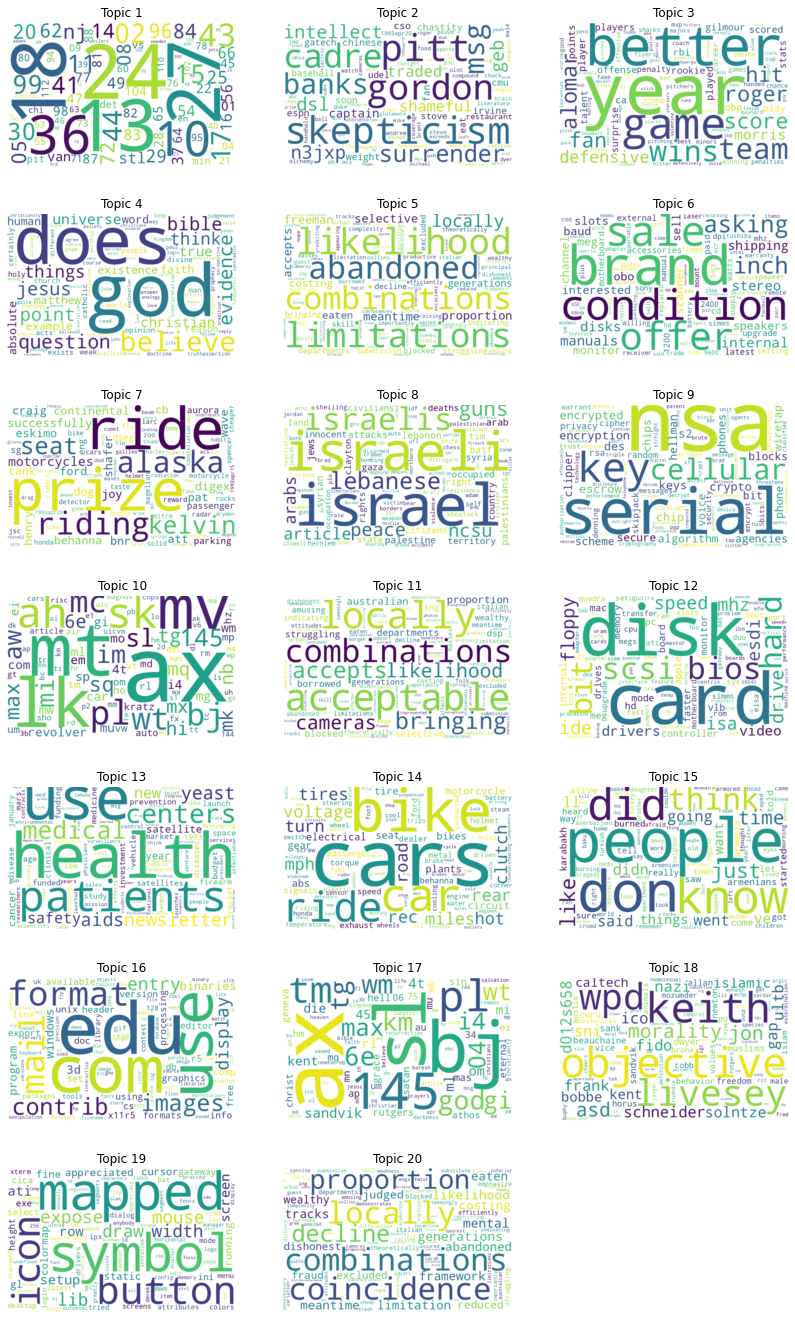

In [11]:
def plot_word_cloud(b, ax, v, n):
    indices = b.argsort()[::-1]
    sorted_ = b[indices]
    df = pd.DataFrame(indices[:100], columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']], 
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).astype(int).tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    
if not smoke_test:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    fig, axs = plt.subplots(7, 3, figsize=(14, 24))
    for n in range(best_beta.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud(best_beta[n], axs[i, j], vocab, n)
    axs[-1, -1].axis('off');

    plt.show()

As can be observed from the 20 word clouds above, the model successfully found several coherent topics.

## Conclusion
In this tutorial, we have introduced Probabilistic Topic Modeling, Latent Dirichlet Allocation, and implemented ProdLDA in Pyro: a new topic model introduced in 2017 that effectively applies the AEVB inference algorithm to latent Dirichlet allocation. We hope you have fun exploring the power of unsupervised machine learning to manage large archives of documents!

## References
1. Akash Srivastava, & Charles Sutton. (2017). Autoencoding Variational Inference For Topic Models.
2. Blei, D. (2012). Probabilistic Topic Models. Commun. ACM, 55(4), 77–84.
3. Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
4. Lau, J. H.  and Newman, D., & Baldwin, T. (2014). Machine Reading Tea Leaves: Automatically Evaluating Topic Coherence and Topic Model Quality. EACL, 530-539